<a href="https://colab.research.google.com/github/ShahedSabab/Rain-prediction/blob/master/rainPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [300]:
!pip3 install ann_visualizer

In [0]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
import missingno
from sklearn.preprocessing import LabelEncoder
from torch import nn, optim
from imblearn.over_sampling import SMOTE, ADASYN
from ann_visualizer.visualize import ann_viz;
import torch.nn.functional as F

# Initialize Variables

In [302]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS_PALETTE))
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Download and read Input data

In [303]:
!gdown --id 1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7

Downloading...
From: https://drive.google.com/uc?id=1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7
To: /content/weatherAUS.csv
14.2MB [00:00, 38.8MB/s]


In [0]:
df = pd.read_csv(
    "weatherAUS.csv",
    parse_dates=['Date'],
    index_col = "Date"
)

# Check Data

In [305]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


# Number of instances per location

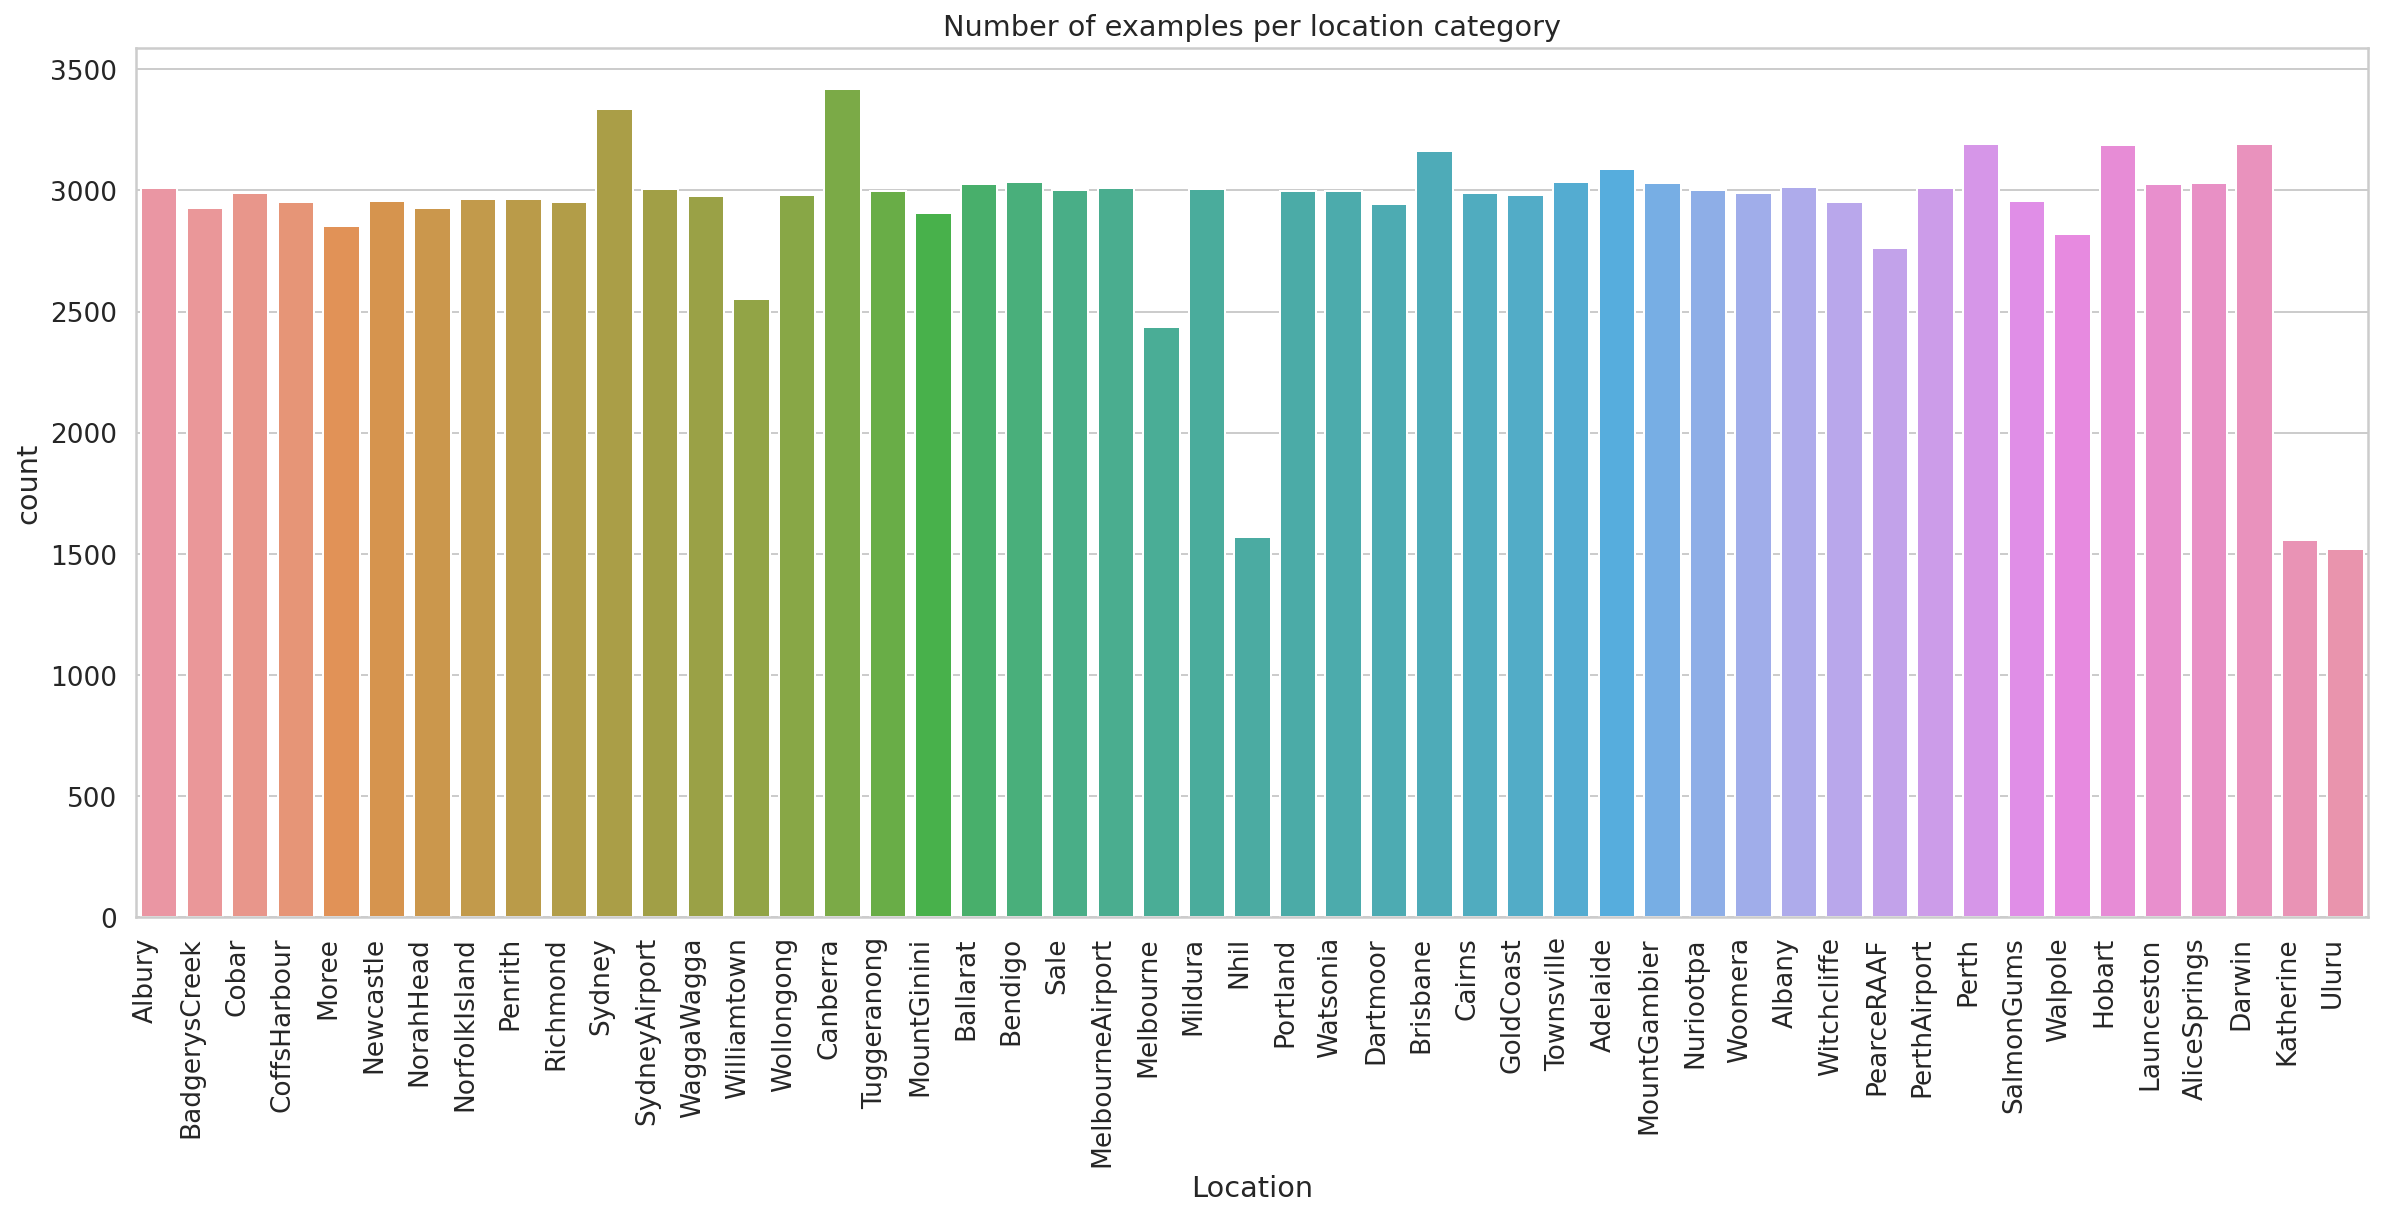

In [306]:
#Check number of exampels per category
plt.figure(figsize=(20,8))
chart = sns.countplot(df.Location)
plt.title("Number of examples per location category")
chart.set_xticklabels(chart.get_xticklabels(), rotation = 90, horizontalalignment= 'right')
plt.show()

# Check missing Values

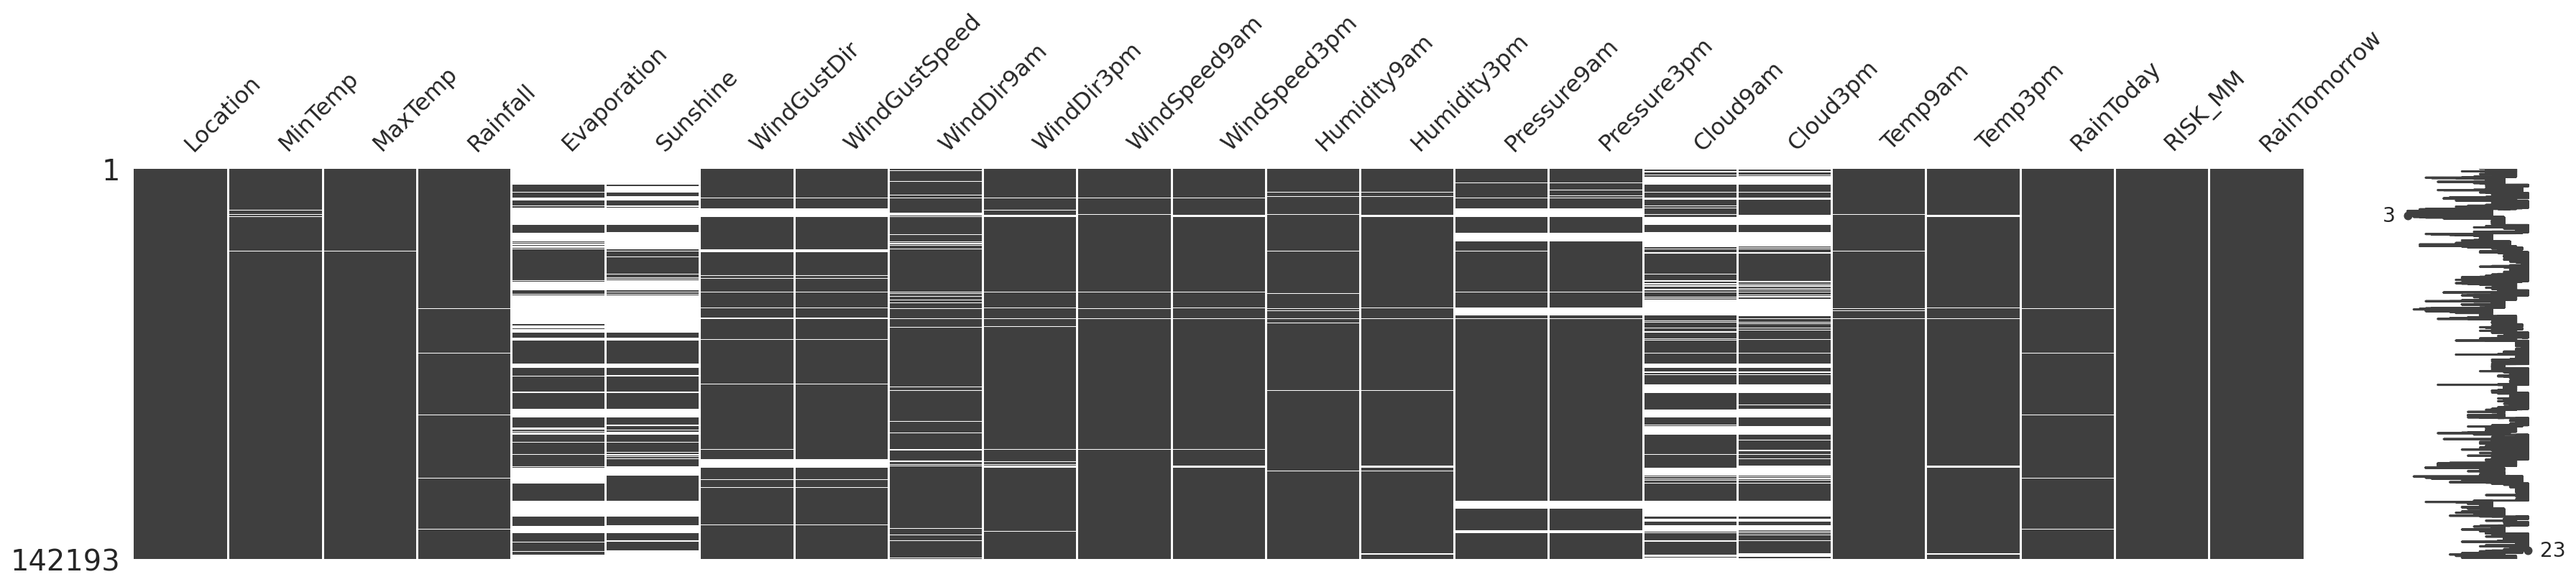

In [307]:
# Check missing values
missingno.matrix(df, figsize = (30,5))

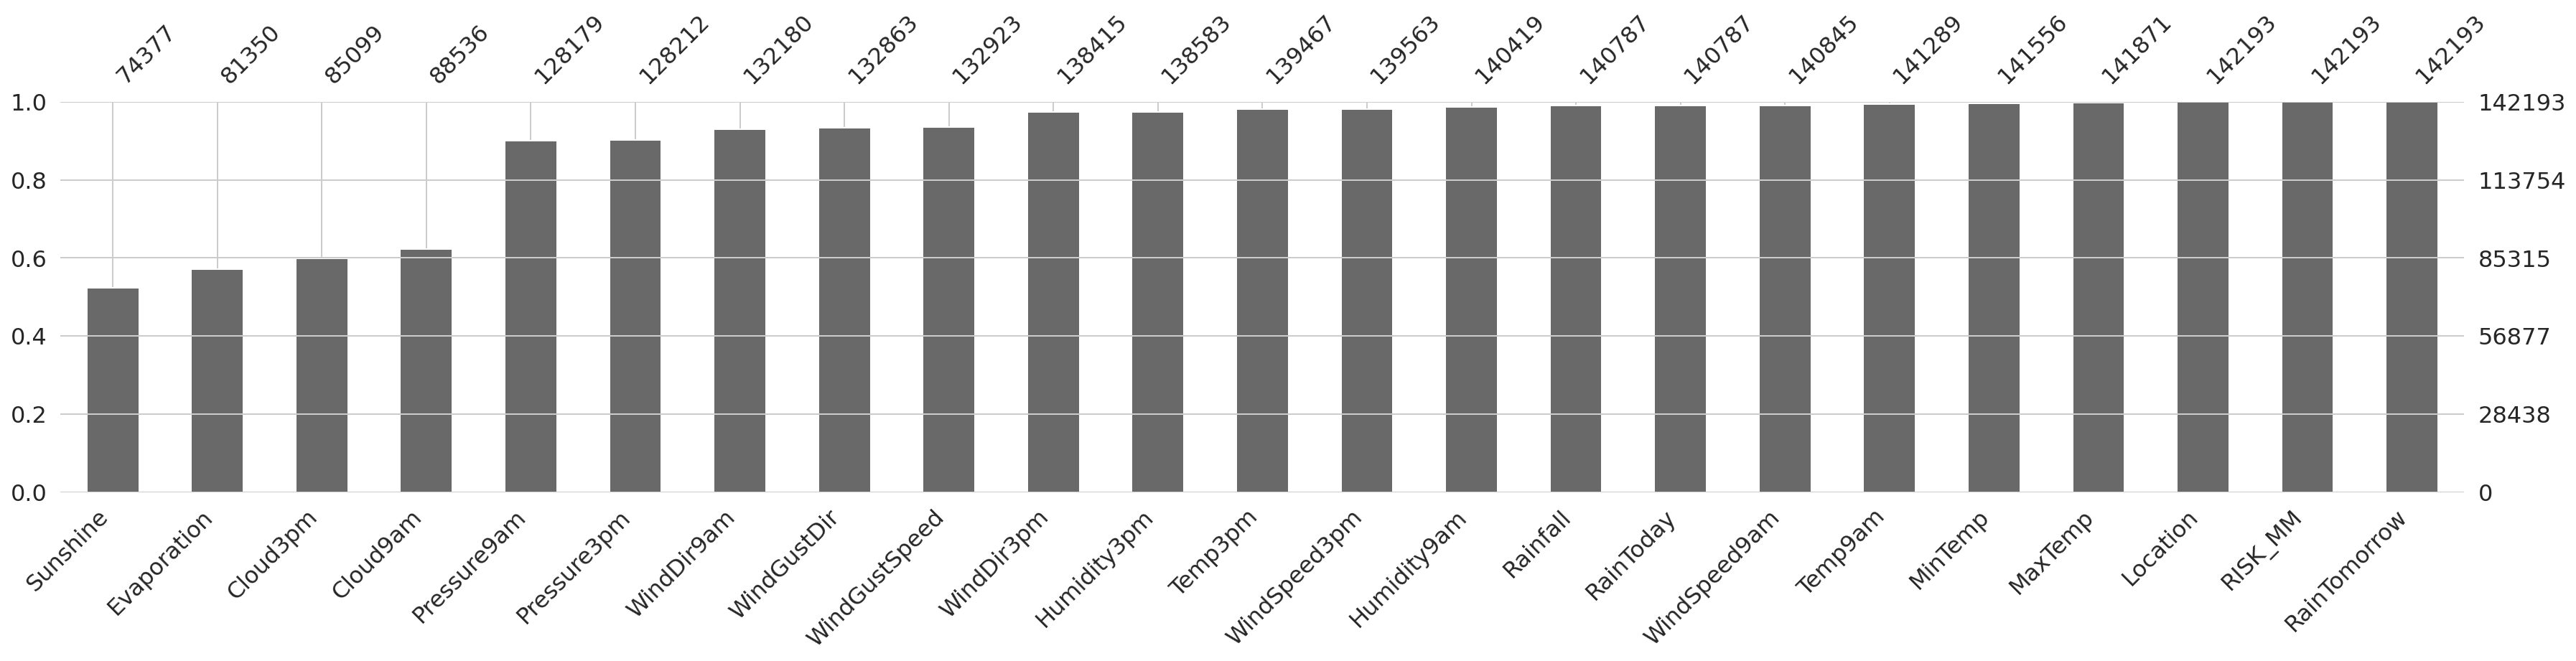

In [308]:
missingno.bar(df, sort='ascending', figsize = (30,5))

In [309]:
#check null values
df.isna().sum().sort_values(ascending=False)

Sunshine         67816
Evaporation      60843
Cloud3pm         57094
Cloud9am         53657
Pressure9am      14014
Pressure3pm      13981
WindDir9am       10013
WindGustDir       9330
WindGustSpeed     9270
WindDir3pm        3778
Humidity3pm       3610
Temp3pm           2726
WindSpeed3pm      2630
Humidity9am       1774
RainToday         1406
Rainfall          1406
WindSpeed9am      1348
Temp9am            904
MinTemp            637
MaxTemp            322
RainTomorrow         0
RISK_MM              0
Location             0
dtype: int64

In [310]:
df.shape

(142193, 23)

# Encode categorical columns

In [311]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
categorical_columns = list(df.columns[categorical_feature_mask])
categorical_columns

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [312]:
# Encode categorical columns
labelEncoder = LabelEncoder()
df[categorical_columns] = df[categorical_columns].apply(lambda col: labelEncoder.fit_transform(col.astype(str)))
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,,,
2008-12-01,2,13.4,22.9,0.6,NaN,NaN,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0.0,0
2008-12-02,2,7.4,25.1,0.0,NaN,NaN,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0.0,0
2008-12-03,2,12.9,25.7,0.0,NaN,NaN,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0.0,0
2008-12-04,2,9.2,28.0,0.0,NaN,NaN,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,1.0,0
2008-12-05,2,17.5,32.3,1.0,NaN,NaN,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0.2,0


# Calculate Pearson's correlation

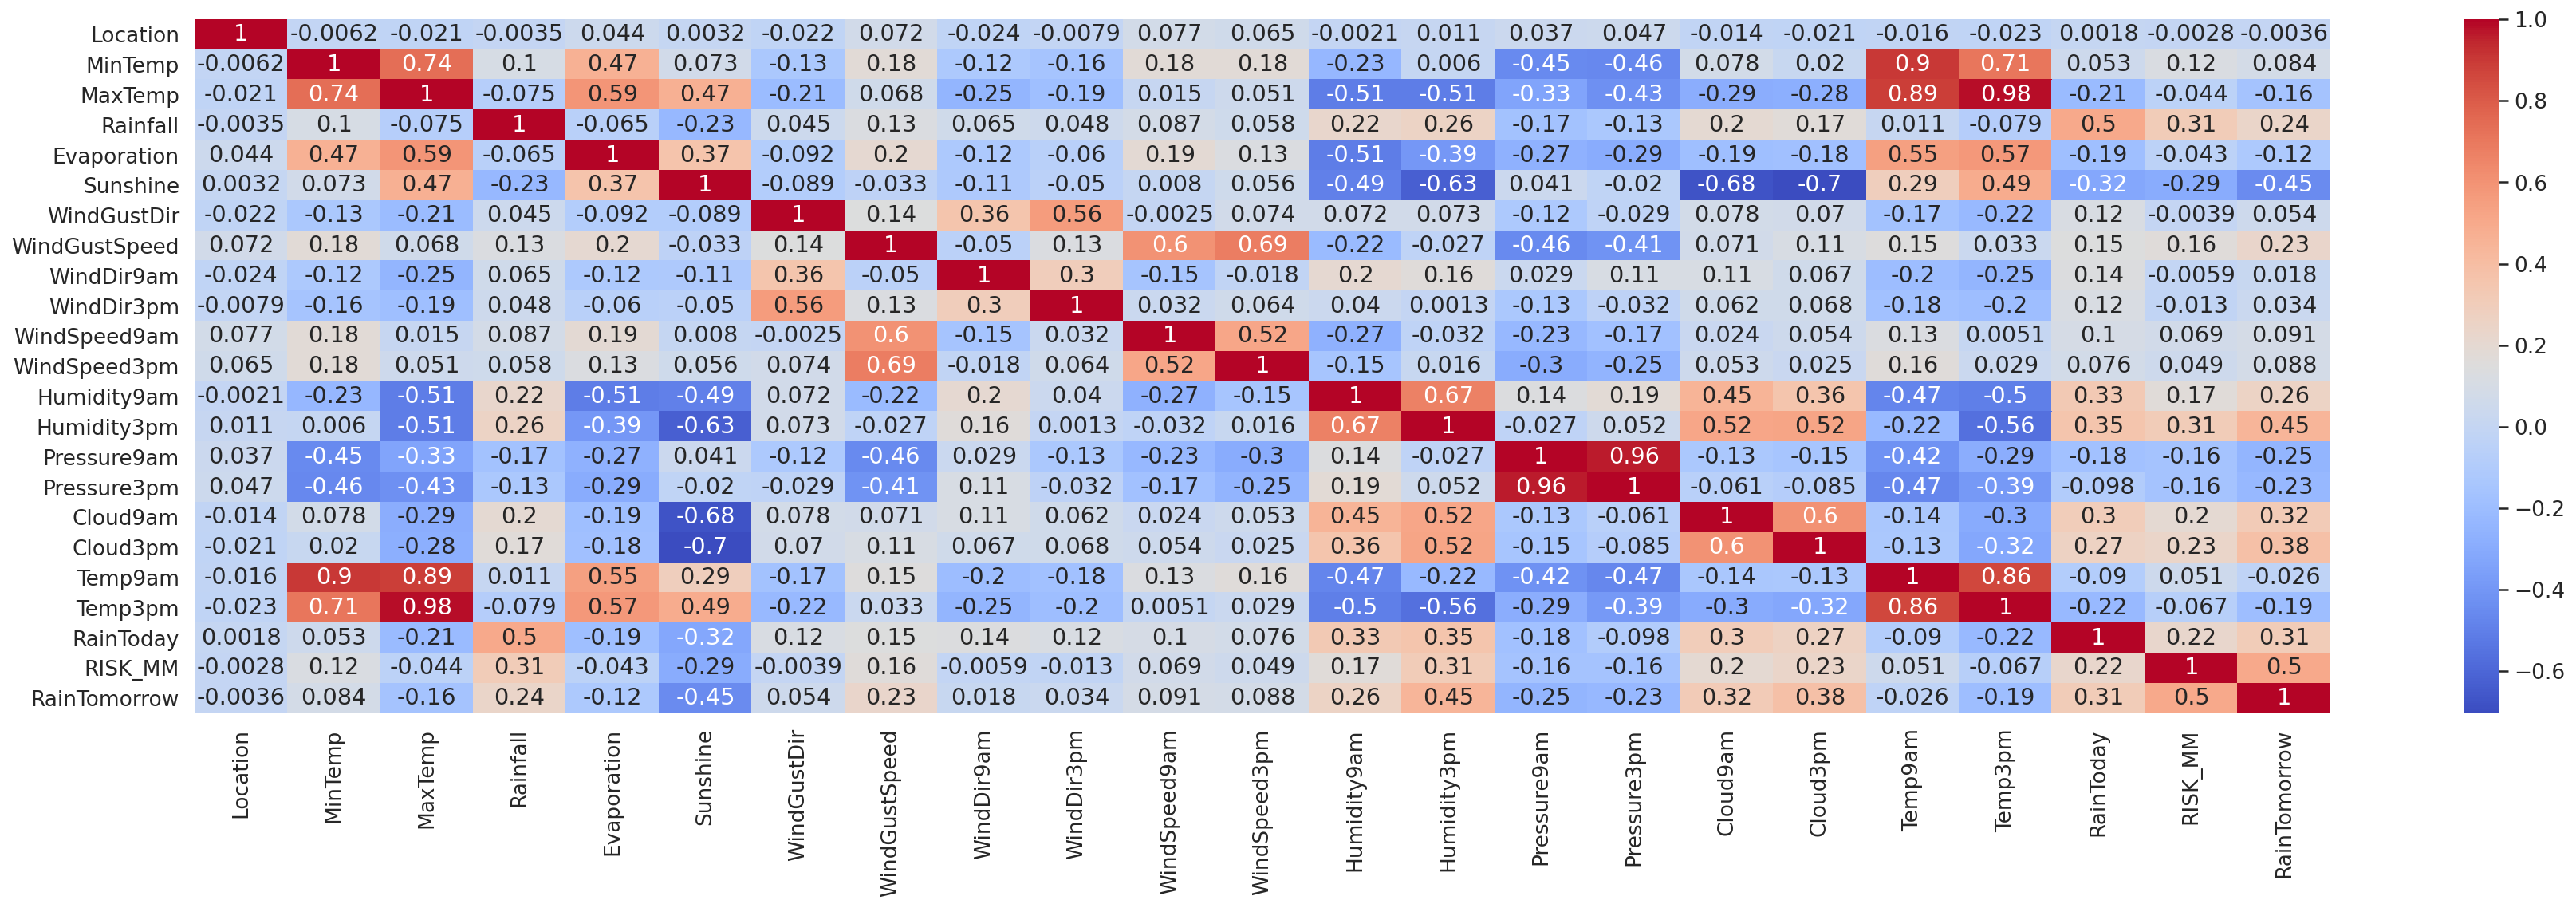

In [313]:
#check Pearson's correlation coeffcient
plt.figure(figsize=(30,8))
sns.heatmap(df.corr(),cmap='coolwarm',annot = True)
plt.show()

In [314]:
# Select features of higher correlation values with Rain Tomorrow   
selected_col = [ 'Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'RainToday', 'RainTomorrow']
df = df[selected_col]
df.head()

,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,RainToday,RainTomorrow
Date,,,,,,
2008-12-01,0.6,44.0,71.0,22.0,0,0
2008-12-02,0.0,44.0,44.0,25.0,0,0
2008-12-03,0.0,46.0,38.0,30.0,0,0
2008-12-04,0.0,24.0,45.0,16.0,0,0
2008-12-05,1.0,41.0,82.0,33.0,0,0


In [315]:
# Check percentage of missing values per selected columns
total = df.isnull().sum().sort_values(ascending=False)
percentage = (total/df.isnull().count()).sort_values(ascending=False)
percentage

WindGustSpeed    0.065193
Humidity3pm      0.025388
Humidity9am      0.012476
Rainfall         0.009888
RainTomorrow     0.000000
RainToday        0.000000
dtype: float64

# Drop missing values

In [316]:
# df['WindGustSpeed'] = df['WindGustSpeed'].fillna(df['WindGustSpeed'].mean())
# df['Humidity3pm'] = df['Humidity3pm'].fillna(df['Humidity3pm'].mean())
# df['Humidity9am'] = df['Humidity9am'].fillna(df['Humidity9am'].mean())
# df['Rainfall'] = df['Rainfall'].fillna(df['Rainfall'].mean())

#drop missing values
df = df.dropna(how='any')
total = df.isnull().sum().sort_values(ascending=False)
percentage = (total/df.isnull().count()).sort_values(ascending=False)
percentage

WindGustSpeed    0.0
Rainfall         0.0
RainTomorrow     0.0
RainToday        0.0
Humidity9am      0.0
Humidity3pm      0.0
dtype: float64

# Train-test split

In [317]:
X = df[df.columns[:-1]]
y = df[df.columns[-1:]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
print("X_tain: {}, y_train: {}; X_test: {}, y_test: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


X_tain: (103565, 5), y_train: (103565, 1); X_test: (25892, 5), y_test: (25892, 1)


# Samping data to balance class distribution

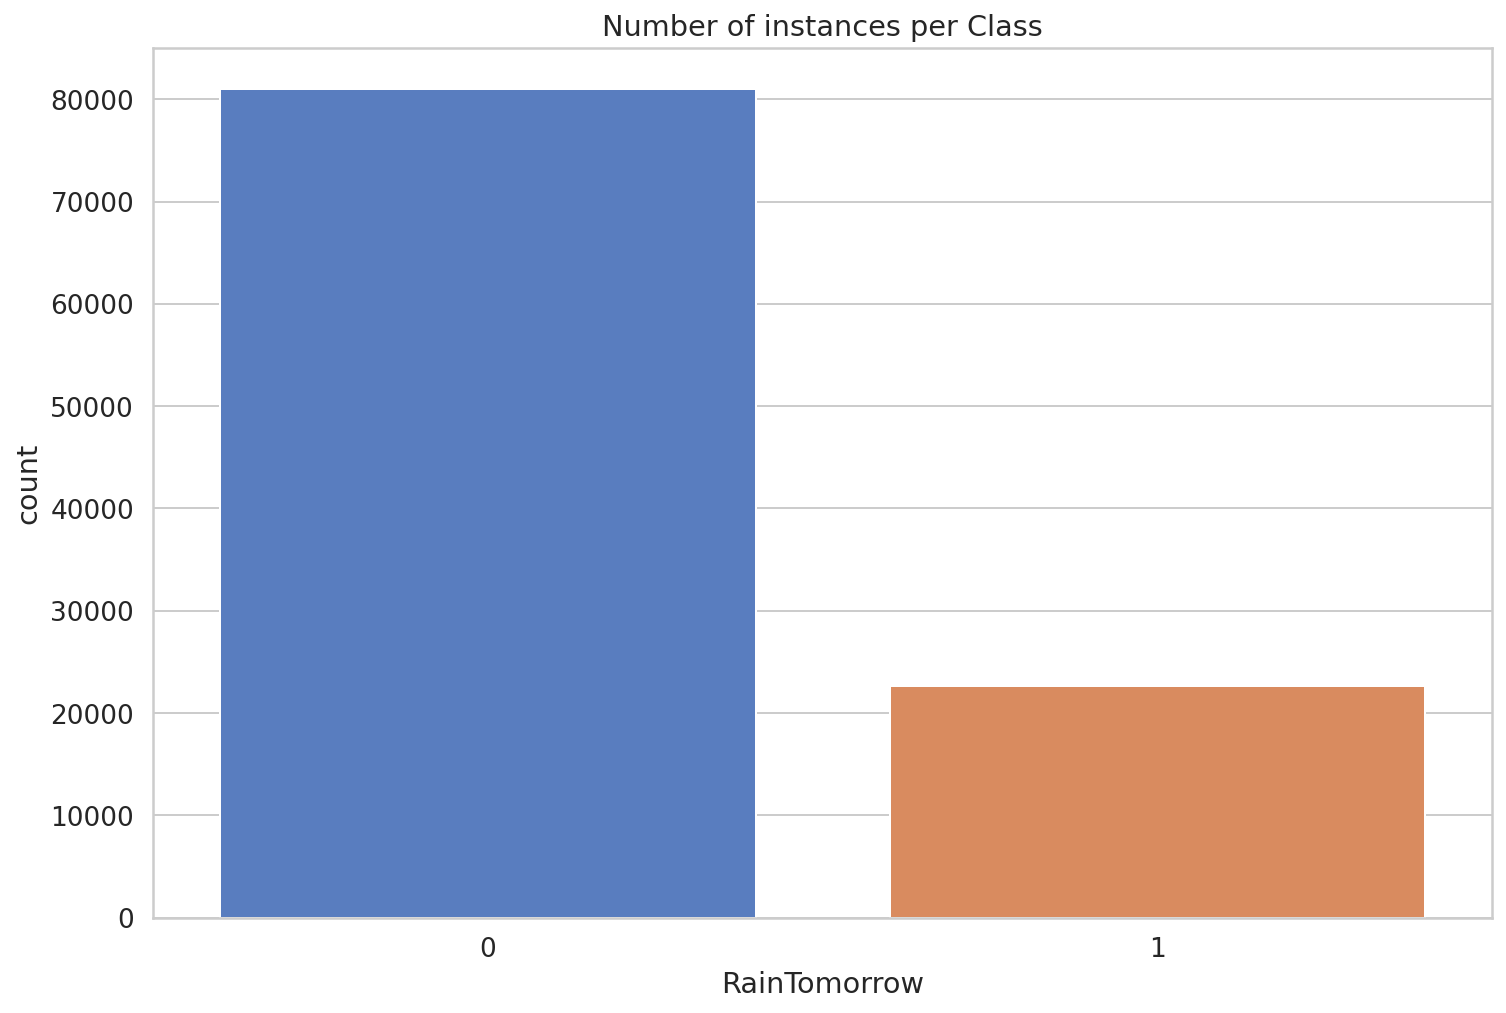

In [318]:
plt.title("Number of instances per Class")
sns.countplot(y_train.RainTomorrow);
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


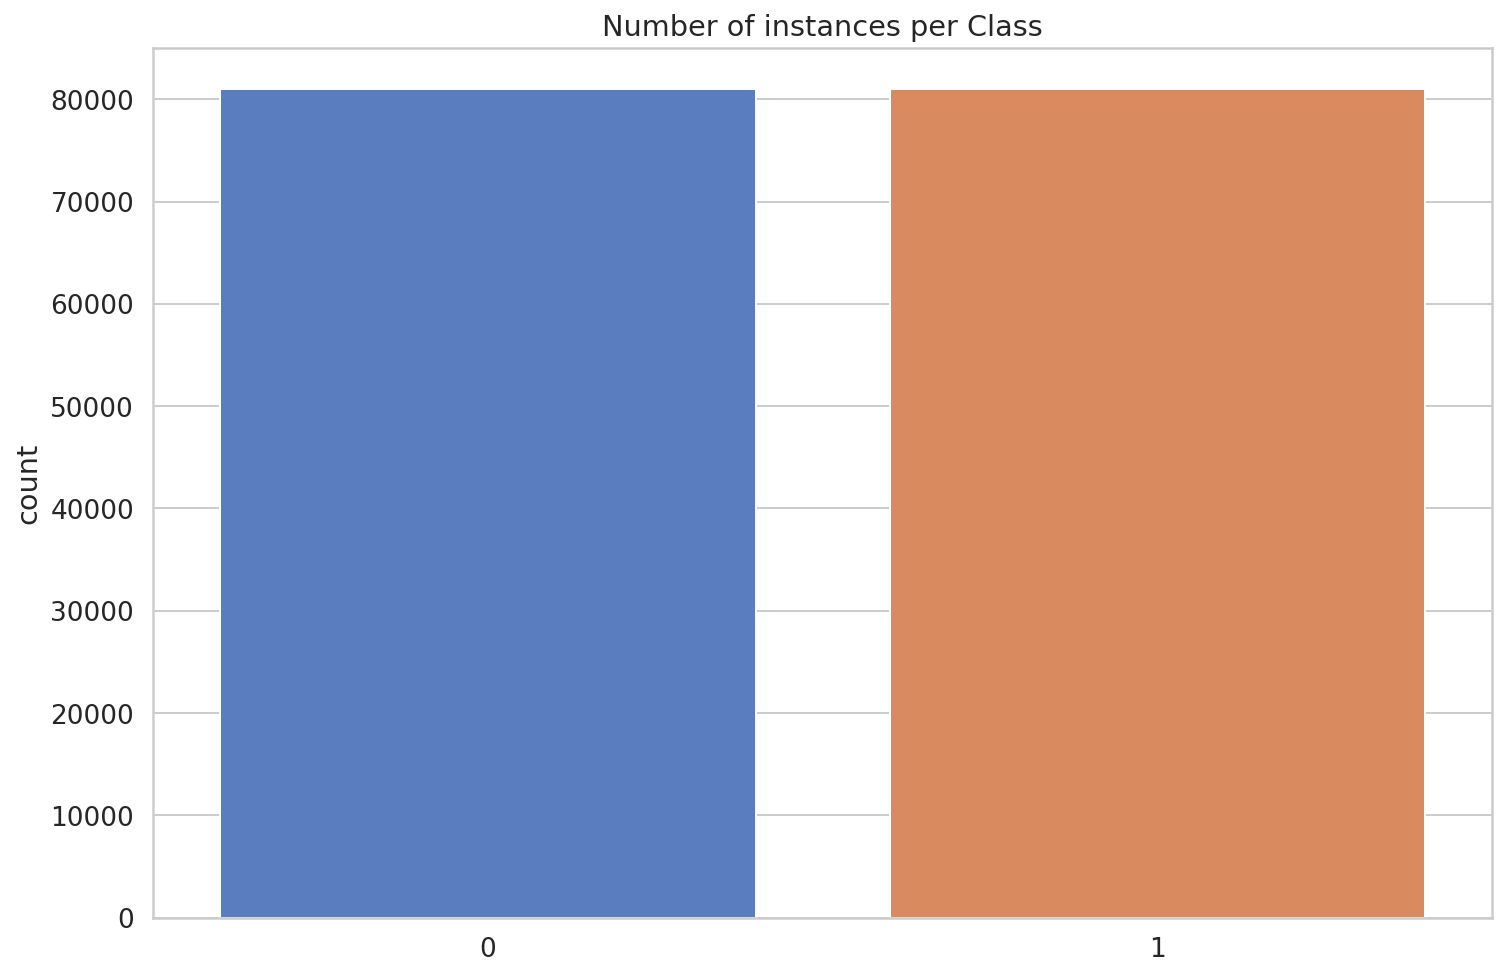

In [319]:
sm = SMOTE(k_neighbors=7)
X_train, y_train = sm.fit_sample(X_train, y_train)

plt.title("Number of instances per Class")
sns.countplot(y_train);
plt.show()

In [0]:
X_train = pd.DataFrame(X_train,columns=[ 'Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'RainToday'])
y_train = pd.DataFrame(y_train, columns = ['RainTomorrow'])

In [321]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([161944, 5]) torch.Size([161944])
torch.Size([25892, 5]) torch.Size([25892])


# Define method for visualizing network

In [0]:
# Heavily based on https://github.com/Prodicode/ann-visualizer

def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.65",
                    style="filled",                    
                    shape="circle",
                    color=COLORS_PALETTE[3],
                    fontcolor=COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=COLORS_PALETTE[0],
                        fontcolor=COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=COLORS_PALETTE[4],
                    fontcolor=COLORS_PALETTE[4],
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


# Define the network

In [0]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 100)
    self.fc2 = nn.Linear(100, 50)
    self.fc3 = nn.Dropout(0.5)
    self.fc4 = nn.Linear(50, 10)
    # self.fc5 = nn.Dropout(0.5)
    # self.fc6 = nn.Linear(5, 5)
    # self.fc7 = nn.Dropout(0.5)
    # self.fc8 = nn.Linear(10, 10)
    self.fc6 = nn.Linear(10, 1)
  

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.relu(self.fc4(x))
    # x = self.fc5(x)
    # x = F.relu(self.fc6(x))
    # x = self.fc7(x)
    # x = F.relu(self.fc8(x))
    return torch.sigmoid(self.fc6(x))

# Check the network through visualization

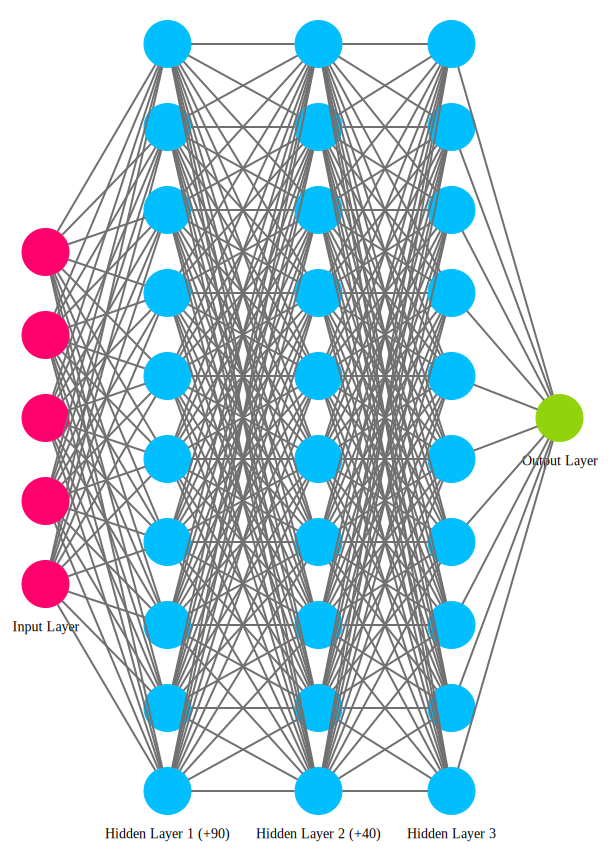

In [324]:
net = Net(X_train.shape[1])

ann_viz(net, view=False)

# Train-validation split

In [0]:
 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_SEED) 

# Define model parameters

In [0]:
net = Net(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.015)

In [327]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
X_train = X_train.to(device)
X_val = X_val.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [329]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(7000):

    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    train_acc = calculate_accuracy(y_train, y_pred)

    y_val_pred = net(X_val)
    y_val_pred = torch.squeeze(y_val_pred)
    val_loss = criterion(y_val_pred, y_val)
    val_acc = calculate_accuracy(y_val, y_val_pred)


    if epoch % 100 == 0:  
      print(
          f'''epoch {epoch}
          Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
          Validation set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
          ''')

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

epoch 0
          Train set - loss: 1.041, accuracy: 0.501
          Validation set - loss: 1.055, accuracy: 0.494
          
epoch 100
          Train set - loss: 0.547, accuracy: 0.725
          Validation set - loss: 0.546, accuracy: 0.723
          
epoch 200
          Train set - loss: 0.554, accuracy: 0.721
          Validation set - loss: 0.55, accuracy: 0.725
          
epoch 300
          Train set - loss: 0.489, accuracy: 0.762
          Validation set - loss: 0.488, accuracy: 0.764
          
epoch 400
          Train set - loss: 0.487, accuracy: 0.763
          Validation set - loss: 0.487, accuracy: 0.765
          
epoch 500
          Train set - loss: 0.482, accuracy: 0.767
          Validation set - loss: 0.48, accuracy: 0.769
          
epoch 600
          Train set - loss: 0.48, accuracy: 0.768
          Validation set - loss: 0.479, accuracy: 0.769
          
epoch 700
          Train set - loss: 0.481, accuracy: 0.767
          Validation set - loss: 0.479, accuracy

# Save Model

In [330]:
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Evaluation

In [337]:
net = torch.load(MODEL_PATH)
classes = ['No rain', 'Rain']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.91      0.83      0.86     20243
        Rain       0.53      0.70      0.60      5649

    accuracy                           0.80     25892
   macro avg       0.72      0.76      0.73     25892
weighted avg       0.82      0.80      0.81     25892



# Check confusion matrix

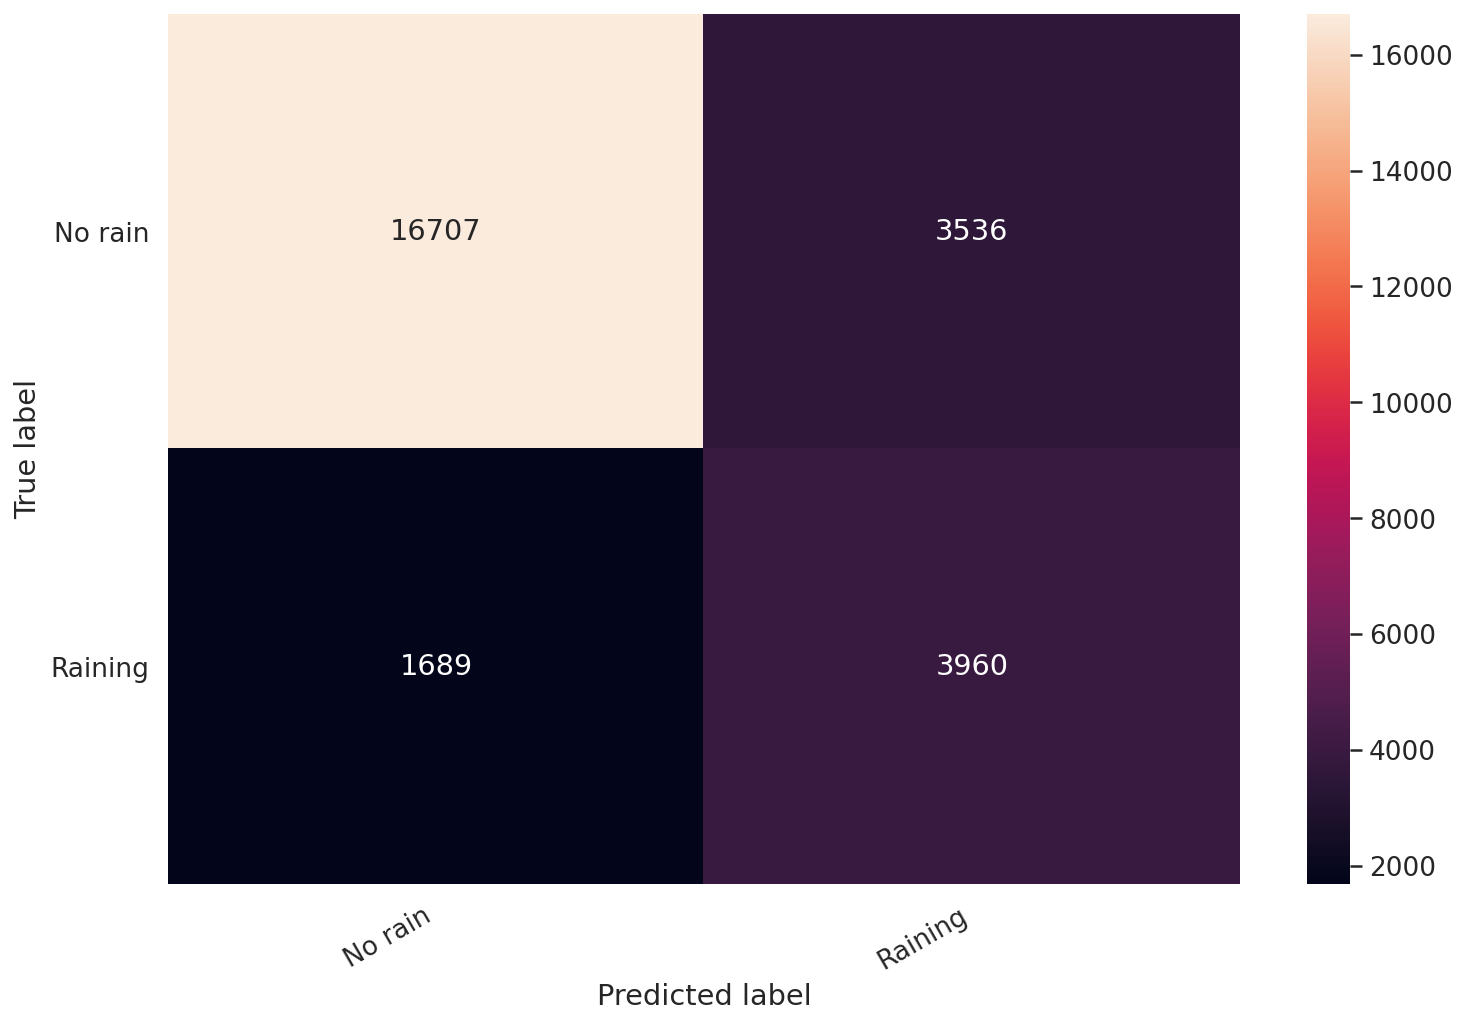

In [336]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');